# Data-Driven Soccer Scouting: Identifying Ball-Playing Center Backs  
**DATA 602 Final Project**  
João De Oliveira

## **Abstract**
This project explores how player performance data can be used to evaluate whether a defender fits a team’s tactical style and to help identify potential transfer targets. The analysis focuses on defenders from the 2021–2022 European football season and looks specifically at players who would suit a ball-dominant system that values controlled possession and forward ball progression.

After cleaning and preparing the data, exploratory analysis was used to examine which performance metrics best distinguish different defender playing styles. Metrics related to passing and ball involvement—such as progressive passing distance, passing accuracy, total passes, carries, and touches—showed more variation across players than purely defensive actions. This suggests that these metrics are more useful for assessing how well a defender fits a possession-based tactical approach.

To summarize overall fit, a Style Fit Score was created by combining several key metrics related to passing and ball control. This score highlights a small group of defenders who most closely match the desired tactical profile. In addition, a similarity-based approach was used to identify players whose overall performance profiles are most similar to a selected reference defender.
The results show that simple, interpretable data analysis methods can help narrow large player pools and support scouting decisions by identifying defenders who are likely to adapt well to a specific tactical style.


## **Introduction**

Modern football scouting increasingly relies on data to support recruitment and tactical decisions. Teams that favor a ball-dominant style of play, especially those that build from the back, require defenders who are comfortable on the ball and able to move play forward under pressure. However, identifying players who fit this tactical profile can be difficult when relying on reputation or traditional statistics alone.

This project examines how player performance data can be used to evaluate whether defenders are well suited to a ball-dominant, vertically progressive tactical system. The analysis focuses on defenders from the 2021–2022 European football season and asks two main questions: which performance metrics best reflect tactical fit, and how can those metrics be used to identify potential transfer targets for specific positions?

By combining exploratory data analysis, a simple scoring approach, and similarity-based comparisons, this project demonstrates how data can support scouting decisions in a transparent and practical way.

## **Data Description**

The dataset used in this project contains player performance statistics from the 2021–2022 European football season and was sourced from publicly available match and player data compiled by FBref. It includes information for approximately 2,900 players across multiple European leagues and covers a wide range of performance metrics. Key variables used in this analysis include player position, minutes played, passing accuracy, progressive passing distance, ball carries, total touches, tackles won, and interceptions. These variables provide insight into both possession-based contributions and defensive actions, making them well suited for evaluating defender playing styles and tactical fit.

## **Data Wrangling**

The dataset required several preprocessing steps before analysis. The data were loaded using a flexible parsing approach to handle inconsistent formatting and malformed rows. Column names were cleaned to remove invisible characters and extra spacing.

Player names contained character-encoding issues caused by accented characters being read incorrectly. These names were repaired and standardized to ensure consistent identifiers throughout the analysis.

The analysis was limited to defenders, identified using position labels containing “DF.” Players with fewer than 900 minutes played were removed to avoid drawing conclusions from small sample sizes. Selected performance metrics were converted to numeric format, and rows with missing values in these variables were excluded. The final dataset consists of regular-playing defenders with complete data suitable for analysis.

In [3]:
# Config
RAW_URL = "https://raw.githubusercontent.com/JDO-MSDS/DATA602/main/Project/2021-2022%20Football%20Player%20Stats.csv"

MIN_MINUTES = 900
REFERENCE_PLAYER = "Aymeric Laporte"

In [4]:
# Load data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

import unicodedata
import re

# raw url with dataset from my github
RAW_URL = "https://raw.githubusercontent.com/JDO-MSDS/DATA602/main/Project/2021-2022%20Football%20Player%20Stats.csv"

# The reference defender was selected from the top performers on the Style Fit Score to represent an archetypal
# ball-playing, vertical-passing center back.
MIN_MINUTES = 900
REFERENCE_PLAYER = "Aymeric Laporte"

# Load data
df = pd.read_csv(
    RAW_URL,
    encoding="latin1",
    sep=";",
    engine="python",
    quoting=3,
    on_bad_lines="skip"
)

# Clean column names
df.columns = (
    df.columns.astype(str)
    .str.replace("\ufeff", "", regex=False)
    .str.strip()
)

# Required columns
player_col = "Player"
pos_col = "Pos"
squad_col = "Squad"
min_col = "Min"
age_col = "Age"

## **Exploratory Data Analysis (EDA)**

The purpose of the exploratory data analysis is to better understand how defenders differ in their playing styles and to identify which performance metrics are most useful for evaluating tactical fit. In particular, the analysis focuses on metrics related to passing, ball control, and forward progression, as these actions are especially important in a ball-dominant system.

Examining variability across these metrics is important because metrics that show greater variation between players are more effective at distinguishing different roles and styles of play. Metrics with little variation may reflect basic positional requirements but provide less insight into tactical adaptability.

The following visualizations explore the distribution and variability of key defender metrics, illustrate how the Style Fit Score is distributed across players, and examine the relationship between the score and progressive passing. Together, these plots help justify the choice of metrics used later in the similarity-based scouting analysis.

Loaded full dataset: (2921, 143)
Unique Pos values (sample): ['DF' 'MF' 'FW' 'MFFW' 'FWMF' 'GK' 'DFMF' 'FWDF' 'MFDF' 'DFFW' 'GKMF']
Defender subset (DF, Min >= 900): (697, 143)
Using features: ['PasTotCmp', 'PasTotCmp%', 'PasTotPrgDist', 'Carries', 'Touches', 'TklW', 'Int']
After dropping missing feature rows: (697, 143)

=== Metric variability among defenders ===
                     mean        std    min     max
PasTotPrgDist  290.141463  86.423857  45.20  596.90
PasTotCmp       42.684792  12.669538  12.80   86.10
Touches         62.988522  12.085126  35.30  103.50
Carries         37.958106  10.919254  16.70   77.20
PasTotCmp%      80.880488   6.837651  60.40   96.80
Int              1.981994   0.609948   0.39    5.22
TklW             1.136858   0.439540   0.22    2.61


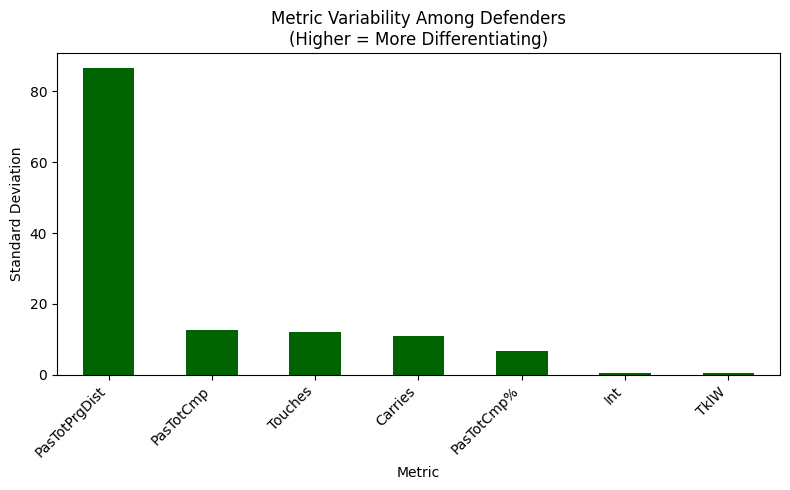

In [11]:
def clean_player_name(name):
    if pd.isna(name):
        return name

    name = str(name)

    try:
        name = name.encode("latin1").decode("utf-8")
    except (UnicodeEncodeError, UnicodeDecodeError):
        pass

    name = unicodedata.normalize("NFKD", name)

    # Remove accents
    name = name.encode("ascii", "ignore").decode("utf-8")

    # Remove junk characters
    name = re.sub(r"[^A-Za-z\s\-\.]", "", name)

    # Normalize spacing
    name = re.sub(r"\s+", " ", name).strip()

    return name


if player_col in df.columns:
    df[player_col] = df[player_col].apply(clean_player_name)

# Convert minutes to numeric
df[min_col] = pd.to_numeric(df[min_col], errors="coerce")

print("Loaded full dataset:", df.shape)
print("Unique Pos values (sample):", df[pos_col].dropna().astype(str).unique()[:20])

# Filter Defenders (DF) + minutes threshold
df_def = df[df[pos_col].astype(str).str.contains("DF", na=False)].copy()
df_def = df_def[df_def[min_col] >= MIN_MINUTES].copy()

print(f"Defender subset (DF, Min >= {MIN_MINUTES}):", df_def.shape)

# 4) Feature set (ball-playing / vertical CB proxy)

features = [
    "PasTotCmp",        # Total completed passes
    "PasTotCmp%",       # Passing accuracy
    "PasTotPrgDist",    # Progressive passing distance
    "Carries",          # Ball carrying volume
    "Touches",          # Buildup involvement
    "TklW",             # Tackles won
    "Int"               # Interceptions
]

# Keep only existing columns
features = [f for f in features if f in df_def.columns]
if len(features) < 3:
    raise ValueError(
        f"Too few feature columns found. Features: {features}\n"
        f"Example columns: {df_def.columns.tolist()[:40]}"
    )

# Convert features to numeric
for f in features:
    df_def[f] = pd.to_numeric(df_def[f], errors="coerce")

# Drop rows missing any feature
X = df_def[features].dropna()
df_def = df_def.loc[X.index].copy()

print("Using features:", features)
print("After dropping missing feature rows:", df_def.shape)

# 5) Exploratory data analysis: metric variability (which metrics matter)
metric_variability = (
    df_def[features]
    .describe()
    .T[["mean", "std", "min", "max"]]
    .sort_values("std", ascending=False)
)

print("\n=== Metric variability among defenders ===")
print(metric_variability.to_string())

# plot with metric variability
plt.figure(figsize=(8, 5))
metric_variability["std"].plot(kind="bar", color="darkgreen")
plt.title("Metric Variability Among Defenders\n(Higher = More Differentiating)")
plt.ylabel("Standard Deviation")
plt.xlabel("Metric")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("viz1_metric_variability.png", dpi=200)
plt.show()

**Metric Variability Among Defenders Plot Interpretation**  
This chart shows how much each performance metric varies across defenders. Metrics related to progressive passing and overall passing volume show the greatest variation, meaning they are better at distinguishing different playing styles. Defensive actions such as tackles and interceptions vary less, suggesting they are necessary skills but less informative for identifying tactical fit.


## Style Fit Score Distribution


=== Top 10 defenders by Style Fit Score ===
          Player           Squad  Age  Min  style_score
 Aymeric Laporte Manchester City 28.0 2828     0.992073
    Thiago Silva         Chelsea 37.0 2650     0.989275
 Dayot Upamecano   Bayern Munich 23.0 2211     0.981743
  William Saliba       Marseille 21.0 3240     0.981205
 Lucas Hernandez   Bayern Munich 26.0 2030     0.975538
     Niklas Sule   Bayern Munich 26.0 1837     0.973565
      Ruben Dias Manchester City 25.0 2402     0.971593
Presnel Kimpembe       Paris S-G 26.0 2576     0.968867
   Manuel Akanji        Dortmund 26.0 2261     0.965674
  Facundo Medina            Lens 23.0 2593     0.962088


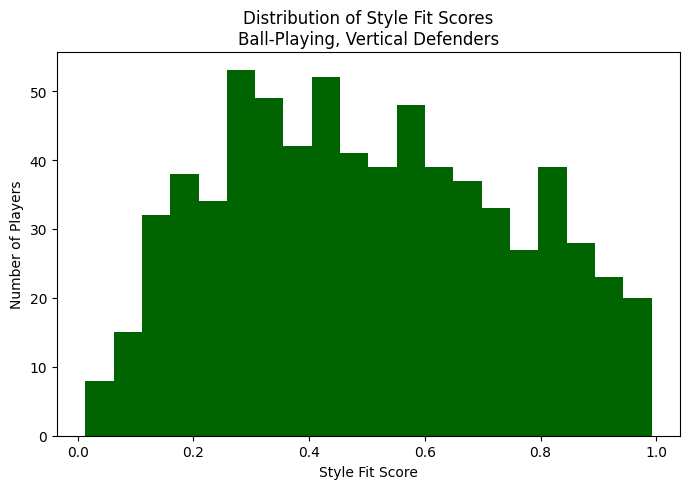

In [12]:
# Style fit score
df_def["style_score"] = (
    df_def["PasTotPrgDist"].rank(pct=True) * 0.35 +
    df_def["PasTotCmp%"].rank(pct=True)   * 0.25 +
    df_def["Carries"].rank(pct=True)      * 0.20 +
    df_def["Touches"].rank(pct=True)      * 0.20
)

top_style_fits = (
    df_def.sort_values("style_score", ascending=False)
    [[player_col, squad_col, age_col, min_col, "style_score"]]
    .head(10)
)

print("\n=== Top 10 defenders by Style Fit Score ===")
print(top_style_fits.to_string(index=False))

# Plot with style score distribution
plt.figure(figsize=(7, 5))
df_def["style_score"].plot(kind="hist", bins=20, color="darkgreen")
plt.title("Distribution of Style Fit Scores\nBall-Playing, Vertical Defenders")
plt.xlabel("Style Fit Score")
plt.ylabel("Number of Players")
plt.tight_layout()
plt.savefig("viz2_style_score_distribution.png", dpi=200)
plt.show()

**Style Fit Score Distribution Plot Interpretation**
The distribution of Style Fit Scores shows that only a small subset of defenders strongly align with the requirements of a ball-dominant, vertical build-up system. This highlights the value of data-driven shortlisting, as most defenders do not naturally fit this tactical profile.


## Style Score vs Progressive Passing

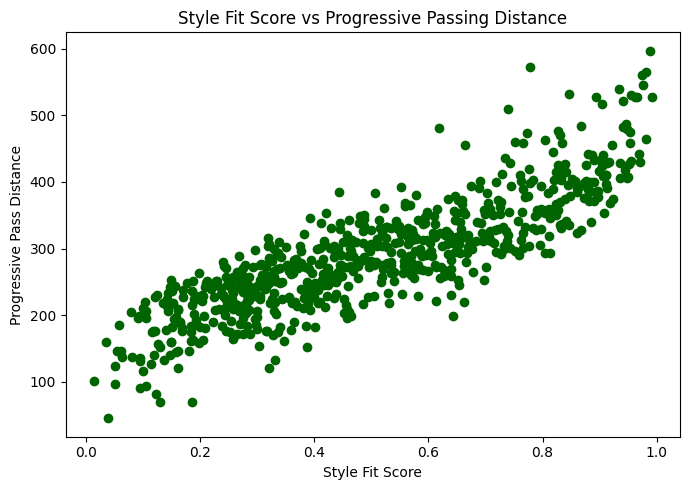

In [13]:
# Plot with style score vs progressive passing
plt.figure(figsize=(7, 5))
plt.scatter(df_def["style_score"], df_def["PasTotPrgDist"], color="darkgreen")
plt.title("Style Fit Score vs Progressive Passing Distance")
plt.xlabel("Style Fit Score")
plt.ylabel("Progressive Pass Distance")
plt.tight_layout()
plt.savefig("viz3_style_score_vs_progression.png", dpi=200)
plt.show()

**Style Fit Score vs Progressive Passing Distance Plot Interpretation**
The positive relationship between Style Fit Score and progressive passing distance validates the construction of the composite score. Defenders with higher style scores tend to contribute more to forward ball progression, supporting the selected metrics as indicators of tactical adaptability.


## Similarity Based Scouting


=== Top 10 Similar Defenders to: Aymeric Laporte ===
         Player           Squad  Age  Min  style_score  similarity
Antonio Rudiger         Chelsea 29.0 3035     0.905918    0.992865
 Duje aleta-Car       Marseille 25.0 2057     0.950933    0.991764
   Gerard Pique       Barcelona 35.0 2092     0.911514    0.988822
         Patric           Lazio 29.0 1649     0.949067    0.985492
  Hamari Traore          Rennes 30.0 2890     0.789921    0.985098
     Marquinhos       Paris S-G 28.0 2861     0.954304    0.985056
   Jules Kounde         Sevilla 23.0 2736     0.916428    0.980755
    Kyle Walker Manchester City 32.0 1755     0.913666    0.980497
     Ruben Dias Manchester City 25.0 2402     0.971593    0.979203
  Calar Soyuncu  Leicester City 26.0 2497     0.811478    0.975381


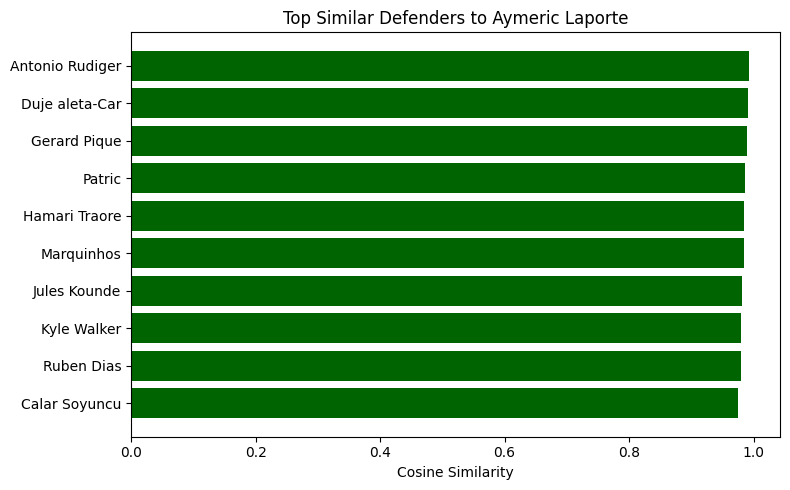

In [14]:
# Similarity scouting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_def[features])

ref_mask = df_def[player_col].astype(str).str.strip().eq(REFERENCE_PLAYER)

if ref_mask.sum() == 0:
    print(f"\nReference player '{REFERENCE_PLAYER}' not found.")
    print("Pick a reference from the Top Style Fits list:\n")
    print(top_style_fits.to_string(index=False))
    raise ValueError("Choose a REFERENCE_PLAYER that exists in df_def.")

ref_vector = X_scaled[ref_mask.values].mean(axis=0, keepdims=True)

similarity_scores = cosine_similarity(ref_vector, X_scaled)[0]
df_def["similarity"] = similarity_scores

top_matches = (
    df_def[~ref_mask]
    .sort_values("similarity", ascending=False)
    [[player_col, squad_col, age_col, min_col, "style_score", "similarity"]]
    .head(10)
)

print(f"\n=== Top 10 Similar Defenders to: {REFERENCE_PLAYER} ===")
print(top_matches.to_string(index=False))

# Plot with similarity results
top_matches_plot = top_matches.sort_values("similarity")

plt.figure(figsize=(8, 5))
plt.barh(top_matches_plot[player_col], top_matches_plot["similarity"], color="darkgreen")
plt.title(f"Top Similar Defenders to {REFERENCE_PLAYER}")
plt.xlabel("Cosine Similarity")
plt.tight_layout()
plt.savefig("viz4_similarity_top_matches.png", dpi=200)
plt.show()

**Top Similar Defenders to chosen target: Aymeric Laporte Plot Interpretation**  
This visualization displays the defenders most similar to the selected reference player (Aymeric Laporte) based on cosine similarity. These players represent viable transfer targets whose statistical profiles closely match the ball-playing center back archetype.


In [10]:
# Save output tables as csv
metric_variability.to_csv("metric_variability_defenders.csv")
top_style_fits.to_csv("top_style_fits.csv", index=False)
top_matches.to_csv("top_similarity_matches.csv", index=False)

print("\nSaved outputs:")
print("- viz1_metric_variability.png")
print("- viz2_style_score_distribution.png")
print("- viz3_style_score_vs_progression.png")
print("- viz4_similarity_top_matches.png")
print("- metric_variability_defenders.csv")
print("- top_style_fits.csv")
print("- top_similarity_matches.csv")



Saved outputs:
- viz1_metric_variability.png
- viz2_style_score_distribution.png
- viz3_style_score_vs_progression.png
- viz4_similarity_top_matches.png
- metric_variability_defenders.csv
- top_style_fits.csv
- top_similarity_matches.csv


## **Conclusions**

This project shows that defender adaptability to a tactical style can be assessed using player performance data. Metrics related to passing, ball involvement, and forward progression are more useful for identifying tactical fit than defensive actions alone.

The Style Fit Score provides a simple way to summarize how well a defender aligns with a ball-dominant, vertically progressive system. Using this score alongside similarity-based comparisons makes it possible to identify players with comparable profiles who could serve as potential transfer targets.

Overall, the analysis demonstrates that straightforward and interpretable data analysis methods can meaningfully support football scouting and recruitment decisions.

## **Limitations and Future Work**

This analysis has several limitations. The dataset covers only one season and does not account for changes in player performance over time. Tactical style is also inferred using statistical measures rather than direct tactical or positional data, which limits contextual interpretation. In addition, factors such as transfer fees, wages, and team-specific needs were not considered.

Future work could extend this analysis by including multiple seasons, incorporating team-level tactical data, or adding financial constraints to produce more realistic recruitment recommendations.